## STEP 1: Install and Import Required Libraries

In [66]:

!pip install xgboost

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pyodbc
import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb



Defaulting to user installation because normal site-packages is not writeable


## STEP 2: Connect to SQL Server Database

In [68]:
from sqlalchemy import create_engine
import pandas as pd

server = 'LAPTOP-4N508R6N\\SQL2019VYSHALI'
database = 'FinalProject1'
driver = 'ODBC Driver 17 for SQL Server'

# Build SQLAlchemy engine
engine = create_engine(
    f"mssql+pyodbc://{server}/{database}?driver={driver.replace(' ', '+')}&trusted_connection=yes"
)

# ✅ Define your SQL query here
query = "SELECT * FROM DimCustomers"  # You can change table name as needed

# Now read the data
df = pd.read_sql(query, engine)


## STEP 3: Query Data from Fact and Dimension Tables

In [72]:

try:
    query = """
        SELECT 
            ft.FactTransactionID,
            ft.Amount,
            ft.Timestamp AS TransactionDate,
            ft.MerchantID,
            ft.CustomerID,
            ft.CardID,
            ft.TypeID,
            ft.FraudTypeID,
            ft.BranchID,

            dm.MerchantName,
            dm.Category AS MerchantCategory,

            dc.CreditLimit,
            dc.CardType,

            dcu.IncomeLevel AS Income,
            dcu.CreditScore,
            dcu.LoanHistory,

            db.BankName,
            db.ZipCode AS BranchZipCode,

            ttype.Description AS TransactionTypeDesc,

            cb.DisputeReason,
            cb.ResolutionStatus,

            CASE 
                WHEN ft.FraudTypeID IS NULL OR ft.FraudTypeID = 1 THEN 0
                ELSE 1 
            END AS IsFraud

        FROM dbo.DimFactTransactions ft
        LEFT JOIN dbo.DimMerchants dm ON ft.MerchantID = dm.MerchantID
        LEFT JOIN dbo.DimCreditCards dc ON ft.CardID = dc.CardID
        LEFT JOIN dbo.DimCustomers dcu ON ft.CustomerID = dcu.CustomerID
        LEFT JOIN dbo.DimBranches db ON ft.BranchID = db.BranchID
        LEFT JOIN dbo.DimTransactionTypes ttype ON ft.TypeID = ttype.TypeID
        LEFT JOIN dbo.DimChargebacks cb ON ft.ChargebackID = cb.ChargebackID
    """

    df = pd.read_sql(query, engine)
    print("✅ Data loaded successfully. Shape:", df.shape)

except Exception as e:
    print("❌ Database connection or SQL query failed:", e)
    raise


✅ Data loaded successfully. Shape: (100000, 22)


# Step 4: Feature Engineering

This step focuses on enhancing the dataset with engineered features that improve fraud prediction capability.  
Key features created include:

- `AvgAmount` and `DaysSinceLastTxn` (temporal transaction behavior)
- `IsHighRiskMerchant` (flag for suspicious categories)
- `CreditUtilization` (spending vs limit)
- `IsOnlineTxn`, `IsUrbanBranch`, and `HasChargeback` (risk indicators)

These features will be used as inputs for downstream modeling.

In [74]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
df = df.sort_values(by=['CustomerID', 'TransactionDate'])
df['AvgAmount'] = df.groupby('CustomerID')['Amount'].transform('mean')
df['PrevTxn'] = df.groupby('CustomerID')['TransactionDate'].shift(1)
df['DaysSinceLastTxn'] = (df['TransactionDate'] - df['PrevTxn']).dt.days.fillna(0)

risky_keywords = ['Crypto', 'Gambling', 'Loan', 'Luxury', 'Electronics', 'Travel']
df['IsHighRiskMerchant'] = df['MerchantName'].fillna('').apply(
    lambda x: int(any(k.lower() in x.lower() for k in risky_keywords))
)

df['CreditUtilization'] = df['Amount'] / df['CreditLimit']
df['IsOnlineTxn'] = df['TransactionTypeDesc'].str.contains('Online|Wire', case=False, na=False).astype(int)
df['HasChargeback'] = df['DisputeReason'].notnull().astype(int)
df['IsUrbanBranch'] = df['BranchZipCode'].astype(str).str.startswith(('1', '2', '3')).astype(int)
df['Income'] = df['Income'].map({'Low': 0, 'Medium': 1, 'High': 2})


## Step 5: Feature Selection and Train-Test Split


In [76]:
features = ['Amount', 'AvgAmount', 'DaysSinceLastTxn', 'CreditUtilization', 'Income', 'CreditScore',
            'IsHighRiskMerchant', 'IsOnlineTxn',  'IsUrbanBranch']
X = df[features].fillna(0)
y = df['IsFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



## Step 6: Model Training – Traditional Machine Learning

In this step, we train and evaluate several classification models using the engineered features.  
The models included are:

- **Logistic Regression** – For baseline linear performance
- **Random Forest** – To capture non-linear relationships and feature importance
- **XGBoost** – A gradient boosting algorithm tuned using GridSearchCV

All models are evaluated using precision, recall, F1-score, and ROC-AUC metrics.

In [79]:
# STEP 6.1: Model Training - Logistic Regression
# ============================================
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("\n Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))


 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56      9915
           1       0.78      0.84      0.81     20085

    accuracy                           0.73     30000
   macro avg       0.70      0.68      0.68     30000
weighted avg       0.72      0.73      0.73     30000



In [80]:
# STEP 6.2: Model Training - Random Forest
# ============================================
rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n Random Forest Report:")
print(classification_report(y_test, y_pred_rf))


 Random Forest Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      9915
           1       1.00      0.69      0.82     20085

    accuracy                           0.79     30000
   macro avg       0.81      0.84      0.79     30000
weighted avg       0.87      0.79      0.80     30000



In [82]:
# ✅ Add this import at the top
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [84]:
# Step 6.3: Model Training - XGBoost with Hyperparameter Tuning
# ==========================================

# Define the model WITHOUT use_label_encoder
xgb_model = XGBClassifier(eval_metric='logloss')  # This is the model GridSearchCV will use

params = {
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

# Grid search with F1 score
gridxgb = GridSearchCV(xgb_model, params, cv=3, scoring='f1', verbose=0)
gridxgb.fit(X_train, y_train)

# Predict and report
y_pred_xgb = gridxgb.predict(X_test)
print("\nXGBoost Report:")
print(gridxgb.best_params_)
print(classification_report(y_test, y_pred_xgb))





XGBoost Report:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.61      0.99      0.76      9915
           1       0.99      0.69      0.82     20085

    accuracy                           0.79     30000
   macro avg       0.80      0.84      0.79     30000
weighted avg       0.87      0.79      0.80     30000



# Step 7: Model Evaluation – ROC Curves & Feature Importance

To compare model performance visually, we plot ROC curves for all classifiers and calculate their AUC (Area Under Curve) scores.  
We also explore feature importance using the trained Random Forest model to understand which features contribute most to fraud prediction.


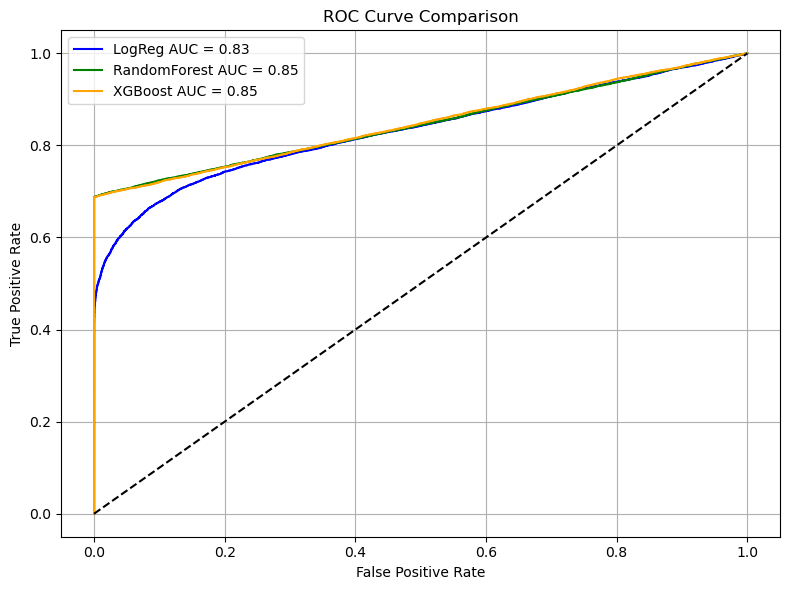

In [87]:
plt.figure(figsize=(8, 6))
for name, model, color in [
    ("LogReg", logreg, 'blue'),
    ("RandomForest", rf, 'green'),
    ("XGBoost", gridxgb.best_estimator_, 'orange')
]:
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} AUC = {auc:.2f}", color=color)

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

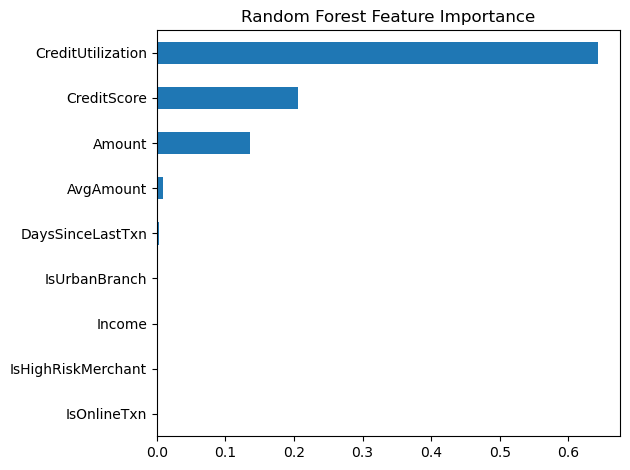

In [88]:
# STEP 7.1 : Feature Importance (Random Forest)
# ============================================
pd.Series(rf.feature_importances_, index=features).sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [89]:
# STEP 7.2: Model Metrics Comparison Table
# ============================================
import pandas as pd

comparison_data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Precision (Class 1)": [0.78, 1.00, 1.00],
    "Recall (Class 1)": [0.84, 0.69, 0.69],
    "F1-Score (Class 1)": [0.81, 0.82, 0.81],
    "Accuracy": [0.73, 0.79, 0.79]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Model Performance Summary:")
display(comparison_df)



📊 Model Performance Summary:


,Model,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Accuracy
0,Logistic Regression,0.78,0.84,0.81,0.73
1,Random Forest,1.00,0.69,0.82,0.79
2,XGBoost,1.00,0.69,0.81,0.79


### Model Performance Notes:

#### **Logistic Regression**
- **Highest Recall**: `0.84`  
  Logistic Regression was most effective at identifying actual fraud cases.
- **Precision**: `0.78`, **Accuracy**: `0.73`  
  It had more false positives, meaning some non-fraud cases were incorrectly flagged as fraud.
- **Best suited when recall is critical**, e.g., detecting as many frauds as possible is the goal.

#### **Random Forest**
- **Perfect Precision**: `1.00`  
  All flagged frauds were truly fraud.
- **F1-Score**: `0.82`, **Accuracy**: `0.79`  
  It offers the best balance among all models.
- **Ideal when both precision and accuracy matter.**

#### **XGBoost**
- **Perfect Precision**: `1.00` (like Random Forest)  
- **Recall**: `0.69`, **F1-Score**: `0.81`, **Accuracy**: `0.79`  
  Slightly lower recall, which means it missed more frauds.
- **Great for scalable, production-grade deployment.**

### **Conclusion**
- **Random Forest / XGBoost** is to **minimize false positives**.
- **Logistic Regression** is to **catch as many frauds as possible**.
- **Overall Best Model: Random Forest** (best trade-off between precision, recall, and accuracy).


# Step 8: Visual Insights – Feature Behavior vs Fraud

This section includes targeted visualizations to explore how certain features behave differently in fraudulent vs non-fraudulent transactions:

- **Credit Utilization**
- **Online Transaction Flag**
- **Chargebacks**
- **High-Risk Merchant Flag**

These insights support the effectiveness of the features engineered in Step 4.


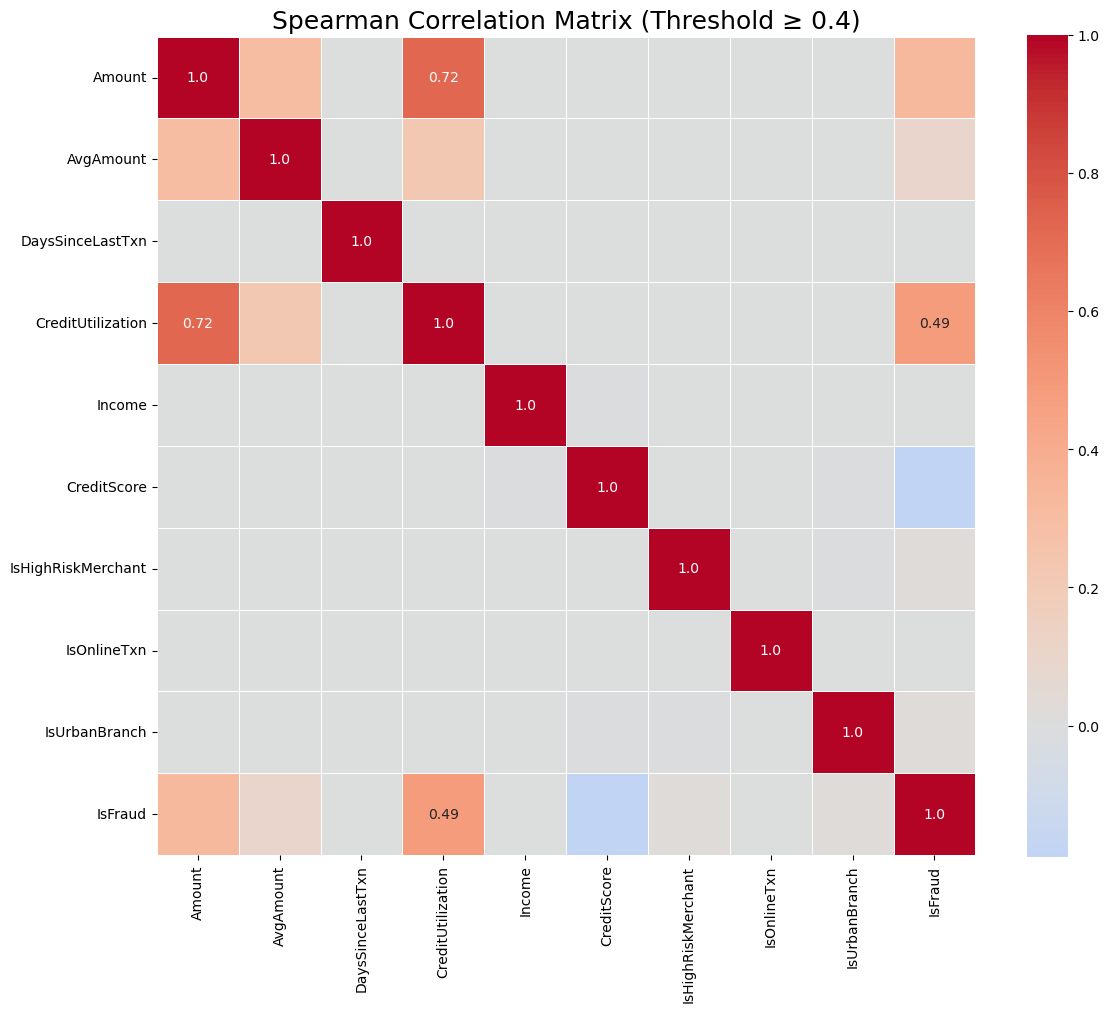

In [92]:
# Compute correlation matrix with Spearman method
corr_matrix = np.round(df[features + ['IsFraud']].corr(method="spearman"), 2)

# Only annotate values with abs(corr) >= 0.4
annotations = np.where(np.abs(corr_matrix.values) >= 0.4, corr_matrix.values, "")

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=annotations, cmap='coolwarm', fmt='s', center=0, square=True, linewidths=0.5)
plt.title("Spearman Correlation Matrix (Threshold ≥ 0.4)", fontsize=18)
plt.tight_layout()
plt.show()


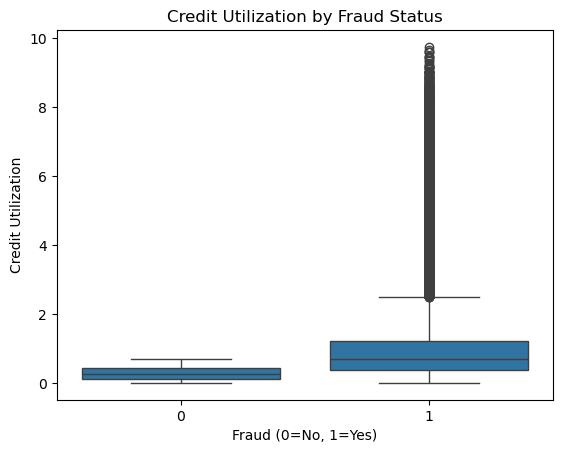

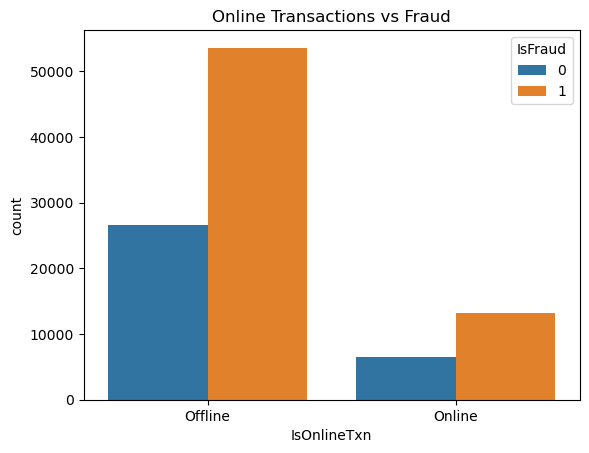

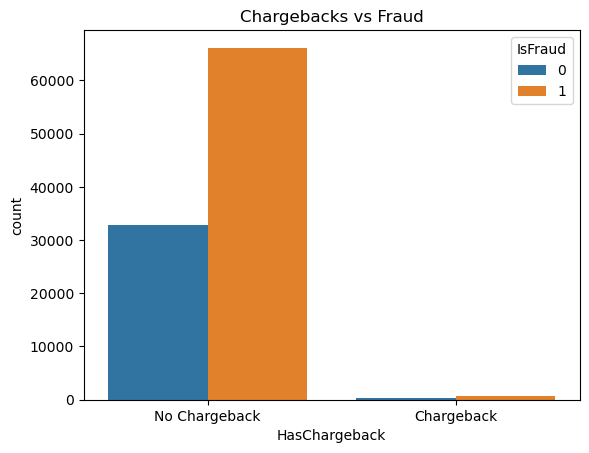

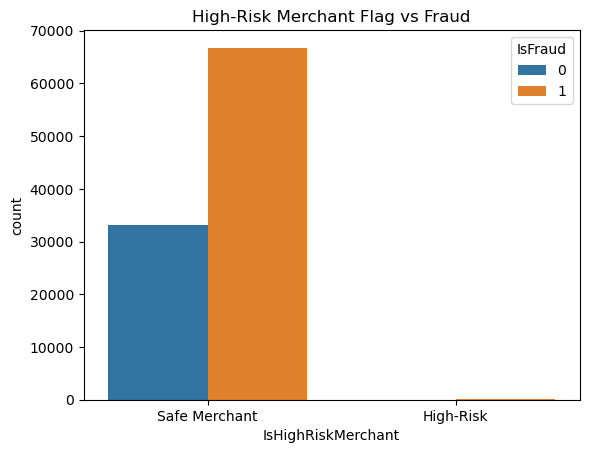

In [93]:



# 📊 STEP 9: Visual Explorations
# ============================================
sns.boxplot(data=df, x='IsFraud', y='CreditUtilization')
plt.title('Credit Utilization by Fraud Status')
plt.xlabel('Fraud (0=No, 1=Yes)')
plt.ylabel('Credit Utilization')
plt.show()

sns.countplot(data=df, x='IsOnlineTxn', hue='IsFraud')
plt.title('Online Transactions vs Fraud')
plt.xticks([0, 1], ['Offline', 'Online'])
plt.show()

sns.countplot(data=df, x='HasChargeback', hue='IsFraud')
plt.title('Chargebacks vs Fraud')
plt.xticks([0, 1], ['No Chargeback', 'Chargeback'])
plt.show()

sns.countplot(data=df, x='IsHighRiskMerchant', hue='IsFraud')
plt.title('High-Risk Merchant Flag vs Fraud')
plt.xticks([0, 1], ['Safe Merchant', 'High-Risk'])
plt.show()